## Perovskite Solar Cells 
**Literature Classification using TF-IDF vectorizer**

This notebook documents one of the approaches we've undertaken to classify relevant literature for our project. Using the dataset `merged_label.csv`, which contains articles categorized as "relevant" or "irrelevant" by our mentor, we aim to build a model that effectively differentiates these categories.

The dataframe is as follows:
- `link`: The URL or reference to the article or journal.
- `label`: A binary label indicating whether the article is relevant (1) or irrelevant (0).
- `text`: The article content extracted from PDFs for text-based analysis.

**1. Importing and Preparing Files**

In [2]:
# Import libraries
import os
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


In [25]:
data = pd.read_csv('data/classifier_training.csv')

### 2. Data Exploration

In [26]:
data.info()
print("\nMissing Values:\n", data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 464 entries, 0 to 463
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  464 non-null    int64 
 1   link        464 non-null    object
 2   label       464 non-null    int64 
 3   text        464 non-null    object
dtypes: int64(2), object(2)
memory usage: 14.6+ KB

Missing Values:
 Unnamed: 0    0
link          0
label         0
text          0
dtype: int64


### 3. Text Vectorization

In [27]:
# Convert the text data to TF-IDF features
tfidf_vectorizer = TfidfVectorizer(max_features=4000)  # Adjust max_features as needed
X = tfidf_vectorizer.fit_transform(data['text'])  
y = data['label'] 

In [28]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 4. Model Selection / Exploration

In [29]:
models = ['Logistic Regression', 'Naive Bayes', 'SVM', 'Random Forest', 'XGBoost']

# list to keep record of performance metric
recall_before = []
accuracy_before = []
ber_before = []

recall_after = []
accuracy_after = []
ber_after = []

# Function to calculate Balanced Error Rate
def balanced_error_rate(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    ber = 1 - (sensitivity + specificity) / 2
    return ber

# Model Evaluation Function with Train/Test Accuracy
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name="Model"):
    # Predictions on test and train sets
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    
    # Accuracy scores
    test_accuracy = accuracy_score(y_test, y_pred_test)
    train_accuracy = accuracy_score(y_train, y_pred_train)
    
    # Classification report for recall
    report = classification_report(y_test, y_pred_test, output_dict=True)
    test_recall = report['1']['recall'] 
    
    # Balanced Error Rate for test set
    test_ber = balanced_error_rate(y_test, y_pred_test)
    
    print(f"\nEvaluation Report for {model_name}:\n")
    print("Classification Report (Test Set):\n", classification_report(y_test, y_pred_test))
    print("Confusion Matrix (Test Set):\n", confusion_matrix(y_test, y_pred_test))
    print(f"Test Accuracy: {test_accuracy}")
    print(f"Train Accuracy: {train_accuracy}")
    print(f"Test Recall): {test_recall}")
    print("Balanced Error Rate (Test Set):", test_ber)
    
    # Return metrics as dictionary for further use
    return {
        "model_name": model_name,
        "train_accuracy": train_accuracy,
        "test_accuracy": test_accuracy,
        "test_recall": test_recall,
        "test_ber": test_ber
    }

In [30]:
# Logistic Regression
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
temp = evaluate_model(lr_model, X_train, X_test, y_train, y_test, model_name="Logistic Regression")
recall_before = recall_before + [temp.get('test_recall')]
accuracy_before = accuracy_before + [temp.get('test_accuracy')]
ber_before = ber_before + [temp.get('test_ber')]


Evaluation Report for Logistic Regression:

Classification Report (Test Set):
               precision    recall  f1-score   support

           0       0.79      1.00      0.88        71
           1       1.00      0.14      0.24        22

    accuracy                           0.80        93
   macro avg       0.89      0.57      0.56        93
weighted avg       0.84      0.80      0.73        93

Confusion Matrix (Test Set):
 [[71  0]
 [19  3]]
Test Accuracy: 0.7956989247311828
Train Accuracy: 0.8355795148247979
Test Recall): 0.13636363636363635
Balanced Error Rate (Test Set): 0.4318181818181819


In [31]:
# Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
temp = evaluate_model(nb_model, X_train, X_test, y_train, y_test, model_name="Naive Bayes")
recall_before = recall_before + [temp.get('test_recall')]
accuracy_before = accuracy_before + [temp.get('test_accuracy')]
ber_before = ber_before + [temp.get('test_ber')]


Evaluation Report for Naive Bayes:

Classification Report (Test Set):
               precision    recall  f1-score   support

           0       0.76      1.00      0.87        71
           1       0.00      0.00      0.00        22

    accuracy                           0.76        93
   macro avg       0.38      0.50      0.43        93
weighted avg       0.58      0.76      0.66        93

Confusion Matrix (Test Set):
 [[71  0]
 [22  0]]
Test Accuracy: 0.7634408602150538
Train Accuracy: 0.8274932614555256
Test Recall): 0.0
Balanced Error Rate (Test Set): 0.5


c:\Users\nicco\source\repos\DSC180_B11_Q2\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\nicco\source\repos\DSC180_B11_Q2\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\nicco\source\repos\DSC180_B11_Q2\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

In [32]:
# Support Vector Machine
svm_model = LinearSVC(random_state=42)
svm_model.fit(X_train, y_train)
temp = evaluate_model(svm_model, X_train, X_test, y_train, y_test, model_name="SVM")
recall_before = recall_before + [temp.get('test_recall')]
accuracy_before = accuracy_before + [temp.get('test_accuracy')]
ber_before = ber_before + [temp.get('test_ber')]


Evaluation Report for SVM:

Classification Report (Test Set):
               precision    recall  f1-score   support

           0       0.85      0.97      0.91        71
           1       0.83      0.45      0.59        22

    accuracy                           0.85        93
   macro avg       0.84      0.71      0.75        93
weighted avg       0.85      0.85      0.83        93

Confusion Matrix (Test Set):
 [[69  2]
 [12 10]]
Test Accuracy: 0.8494623655913979
Train Accuracy: 0.9514824797843666
Test Recall): 0.45454545454545453
Balanced Error Rate (Test Set): 0.2868117797695262


In [33]:
# Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
temp = evaluate_model(rf_model, X_train, X_test, y_train, y_test, model_name="Random Forest")
recall_before = recall_before + [temp.get('test_recall')]
accuracy_before = accuracy_before + [temp.get('test_accuracy')]
ber_before = ber_before + [temp.get('test_ber')]


Evaluation Report for Random Forest:

Classification Report (Test Set):
               precision    recall  f1-score   support

           0       0.84      0.99      0.91        71
           1       0.90      0.41      0.56        22

    accuracy                           0.85        93
   macro avg       0.87      0.70      0.74        93
weighted avg       0.86      0.85      0.83        93

Confusion Matrix (Test Set):
 [[70  1]
 [13  9]]
Test Accuracy: 0.8494623655913979
Train Accuracy: 0.9973045822102425
Test Recall): 0.4090909090909091
Balanced Error Rate (Test Set): 0.30249679897567217


In [34]:
# XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, random_state=42)
xgb_model.fit(X_train, y_train)
temp = evaluate_model(xgb_model, X_train, X_test, y_train, y_test, model_name="XGBoost")
recall_before = recall_before + [temp.get('test_recall')]
accuracy_before = accuracy_before + [temp.get('test_accuracy')]
ber_before = ber_before + [temp.get('test_ber')]

c:\Users\nicco\source\repos\DSC180_B11_Q2\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [18:15:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Evaluation Report for XGBoost:

Classification Report (Test Set):
               precision    recall  f1-score   support

           0       0.92      0.97      0.95        71
           1       0.89      0.73      0.80        22

    accuracy                           0.91        93
   macro avg       0.90      0.85      0.87        93
weighted avg       0.91      0.91      0.91        93

Confusion Matrix (Test Set):
 [[69  2]
 [ 6 16]]
Test Accuracy: 0.9139784946236559
Train Accuracy: 0.9973045822102425
Test Recall): 0.7272727272727273
Balanced Error Rate (Test Set): 0.15044814340588986


### 6. Hyperparameter Tuning

In [35]:
# hiding convergence warning just to make notebook more clean
from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings('ignore', category=ConvergenceWarning)

In [36]:
# number of cross validation folds
cv_n = 5

In [37]:
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'newton-cg', 'sag', 'saga'],
    'max_iter': [50, 100, 200]
}

grid_search_lr = GridSearchCV(LogisticRegression(random_state=42), param_grid_lr, cv=cv_n, scoring='accuracy')
grid_search_lr.fit(X_train, y_train)
print("Best Parameters for Logistic Regression:", grid_search_lr.best_params_)
best_lr_model = grid_search_lr.best_estimator_

Best Parameters for Logistic Regression: {'C': 100, 'max_iter': 50, 'solver': 'newton-cg'}


In [38]:
param_grid_nb = {
    'alpha': [0.001, 0.01, 0.1, 0.5, 1.0]
}

grid_search_nb = GridSearchCV(MultinomialNB(), param_grid_nb, cv=cv_n, scoring='accuracy')
grid_search_nb.fit(X_train, y_train)
print("Best Parameters for Naive Bayes:", grid_search_nb.best_params_)
best_nb_model = grid_search_nb.best_estimator_

Best Parameters for Naive Bayes: {'alpha': 0.5}


In [39]:
param_grid_svm = {
    'C': [0.01, 0.1, 1, 10, 100],
    'loss': ['hinge', 'squared_hinge'],
    'max_iter': [1, 10, 50, 100, 250, 500]
}

grid_search_svm = GridSearchCV(LinearSVC(random_state=42), param_grid_svm, cv=cv_n, scoring='accuracy')
grid_search_svm.fit(X_train, y_train)
print("Best Parameters for SVM:", grid_search_svm.best_params_)
best_svm_model = grid_search_svm.best_estimator_

Best Parameters for SVM: {'C': 100, 'loss': 'squared_hinge', 'max_iter': 100}


In [40]:
param_grid_rf = {
    'n_estimators': [100, 200, 250],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=cv_n, scoring='accuracy')
grid_search_rf.fit(X_train, y_train)
print("Best Parameters for Random Forest:", grid_search_rf.best_params_)
best_rf_model = grid_search_rf.best_estimator_

Best Parameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [41]:
from xgboost import XGBClassifier

param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [2, 3, 6],
    'learning_rate': [0.01, 0.1, 0.2]
}

grid_search_xgb = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss'), 
                               param_grid_xgb, cv=cv_n, scoring='accuracy')
grid_search_xgb.fit(X_train, y_train)
print("Best Parameters for XGBoost:", grid_search_xgb.best_params_)
best_xgb_model = grid_search_xgb.best_estimator_

c:\Users\nicco\source\repos\DSC180_B11_Q2\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [18:19:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\nicco\source\repos\DSC180_B11_Q2\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [18:19:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\nicco\source\repos\DSC180_B11_Q2\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [18:19:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warning

Best Parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}


### 7. Evaluating Models after tuning using GridSearch

In [42]:
temp = evaluate_model(best_lr_model, X_train, X_test, y_train, y_test, model_name="Tuned Logistic Regression")
recall_after = recall_after + [temp.get('test_recall')]
accuracy_after = accuracy_after + [temp.get('test_accuracy')]
ber_after = ber_after + [temp.get('test_ber')]


Evaluation Report for Tuned Logistic Regression:

Classification Report (Test Set):
               precision    recall  f1-score   support

           0       0.87      0.97      0.92        71
           1       0.86      0.55      0.67        22

    accuracy                           0.87        93
   macro avg       0.87      0.76      0.79        93
weighted avg       0.87      0.87      0.86        93

Confusion Matrix (Test Set):
 [[69  2]
 [10 12]]
Test Accuracy: 0.8709677419354839
Train Accuracy: 0.9973045822102425
Test Recall): 0.5454545454545454
Balanced Error Rate (Test Set): 0.2413572343149808


In [43]:
temp = evaluate_model(best_nb_model, X_train, X_test, y_train, y_test, model_name="Tuned Naive Bayes")
recall_after = recall_after + [temp.get('test_recall')]
accuracy_after = accuracy_after + [temp.get('test_accuracy')]
ber_after = ber_after + [temp.get('test_ber')]


Evaluation Report for Tuned Naive Bayes:

Classification Report (Test Set):
               precision    recall  f1-score   support

           0       0.76      1.00      0.87        71
           1       0.00      0.00      0.00        22

    accuracy                           0.76        93
   macro avg       0.38      0.50      0.43        93
weighted avg       0.58      0.76      0.66        93

Confusion Matrix (Test Set):
 [[71  0]
 [22  0]]
Test Accuracy: 0.7634408602150538
Train Accuracy: 0.8274932614555256
Test Recall): 0.0
Balanced Error Rate (Test Set): 0.5


c:\Users\nicco\source\repos\DSC180_B11_Q2\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\nicco\source\repos\DSC180_B11_Q2\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\nicco\source\repos\DSC180_B11_Q2\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

In [44]:
temp = evaluate_model(best_svm_model, X_train, X_test, y_train, y_test, model_name="Tuned SVM")
recall_after = recall_after + [temp.get('test_recall')]
accuracy_after = accuracy_after + [temp.get('test_accuracy')]
ber_after = ber_after + [temp.get('test_ber')]


Evaluation Report for Tuned SVM:

Classification Report (Test Set):
               precision    recall  f1-score   support

           0       0.91      0.97      0.94        71
           1       0.88      0.68      0.77        22

    accuracy                           0.90        93
   macro avg       0.90      0.83      0.85        93
weighted avg       0.90      0.90      0.90        93

Confusion Matrix (Test Set):
 [[69  2]
 [ 7 15]]
Test Accuracy: 0.9032258064516129
Train Accuracy: 0.9973045822102425
Test Recall): 0.6818181818181818
Balanced Error Rate (Test Set): 0.17317541613316267


In [45]:
temp = evaluate_model(best_rf_model, X_train, X_test, y_train, y_test, model_name="Tuned Random Forest")
recall_after = recall_after + [temp.get('test_recall')]
accuracy_after = accuracy_after + [temp.get('test_accuracy')]
ber_after = ber_after + [temp.get('test_ber')]


Evaluation Report for Tuned Random Forest:

Classification Report (Test Set):
               precision    recall  f1-score   support

           0       0.84      0.99      0.91        71
           1       0.90      0.41      0.56        22

    accuracy                           0.85        93
   macro avg       0.87      0.70      0.74        93
weighted avg       0.86      0.85      0.83        93

Confusion Matrix (Test Set):
 [[70  1]
 [13  9]]
Test Accuracy: 0.8494623655913979
Train Accuracy: 0.9973045822102425
Test Recall): 0.4090909090909091
Balanced Error Rate (Test Set): 0.30249679897567217


In [46]:
temp = evaluate_model(best_xgb_model, X_train, X_test, y_train, y_test, model_name="Tuned XGBoost")
recall_after = recall_after + [temp.get('test_recall')]
accuracy_after = accuracy_after + [temp.get('test_accuracy')]
ber_after = ber_after + [temp.get('test_ber')]


Evaluation Report for Tuned XGBoost:

Classification Report (Test Set):
               precision    recall  f1-score   support

           0       0.92      0.97      0.95        71
           1       0.89      0.73      0.80        22

    accuracy                           0.91        93
   macro avg       0.90      0.85      0.87        93
weighted avg       0.91      0.91      0.91        93

Confusion Matrix (Test Set):
 [[69  2]
 [ 6 16]]
Test Accuracy: 0.9139784946236559
Train Accuracy: 0.9973045822102425
Test Recall): 0.7272727272727273
Balanced Error Rate (Test Set): 0.15044814340588986


### 8. Comparing Performance

In [49]:
import numpy as np
import matplotlib.pyplot as plt

def plot_performance(metrics_before, metrics_after, metric_name, ylabel):
    x = np.arange(len(models)) 
    width = 0.35

    fig, ax = plt.subplots(figsize=(22, 10))
    bars1 = ax.bar(x - width/2, metrics_before, width, label='Before Tuning', color='#FFD580')  # Light orange
    bars2 = ax.bar(x + width/2, metrics_after, width, label='After Tuning', color='#FFA500')    # Orange

    # Add labels, title, and custom x-axis tick labels
    ax.set_ylabel(ylabel)
    ax.set_title(f'{metric_name} Before and After Tuning')
    ax.set_xticks(x)
    ax.set_xticklabels(models)
    ax.legend()

    # Attach a text label above each bar, displaying its height
    for bars in [bars1, bars2]:
        for bar in bars:
            ax.annotate(f'{bar.get_height():.2f}',
                        xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    # Turn on grid
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

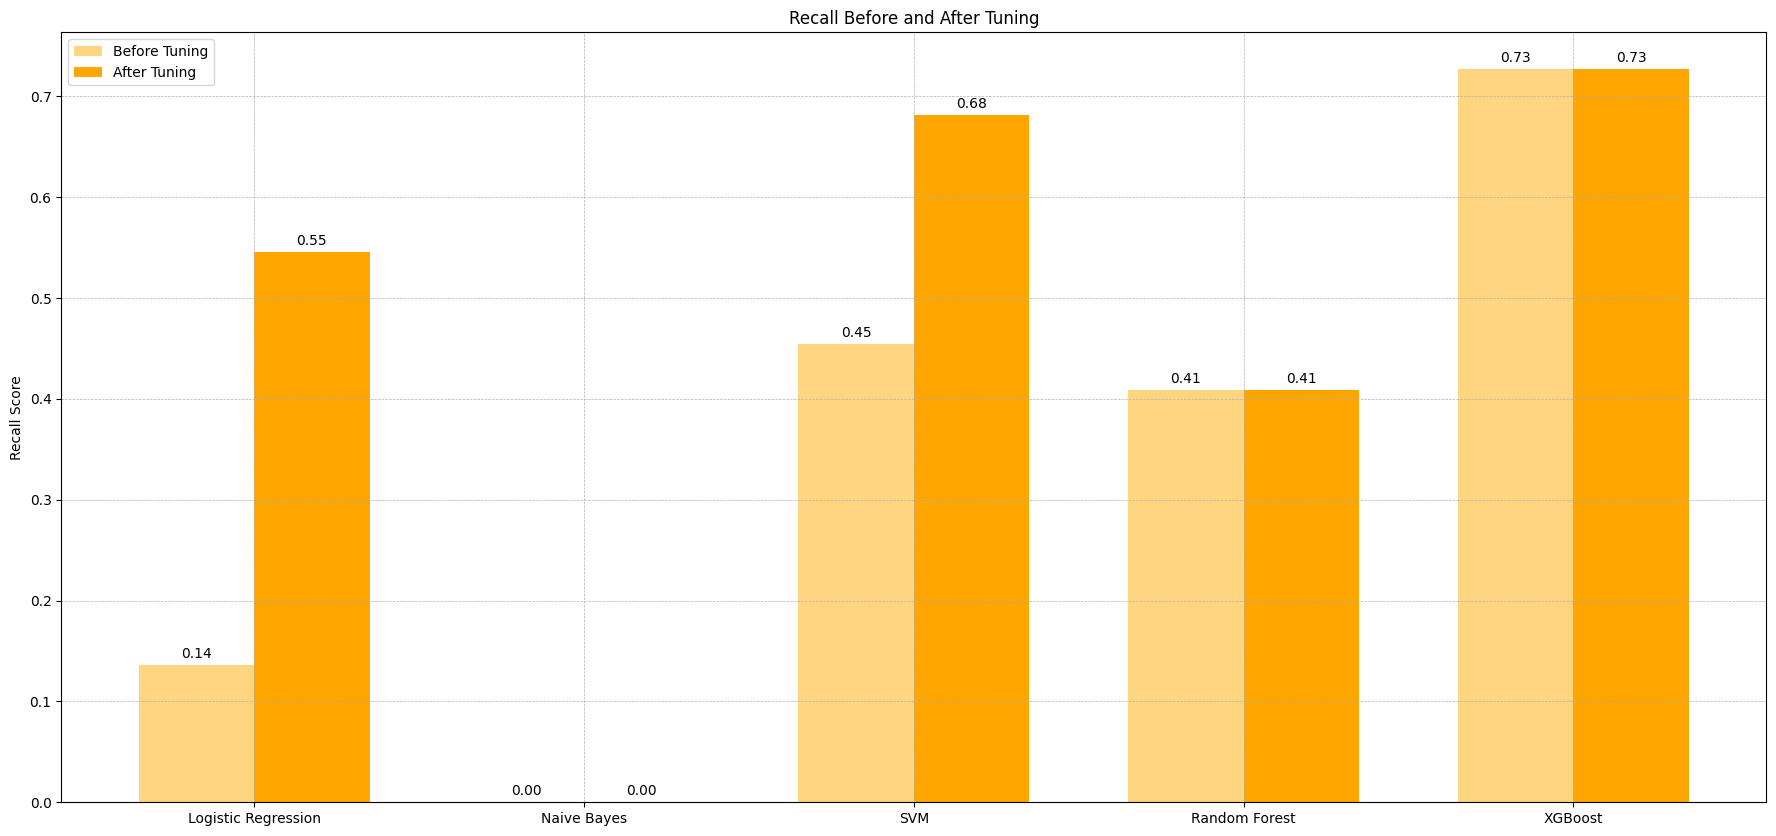

In [50]:
plot_performance(recall_before, recall_after, "Recall", "Recall Score")
plt.savefig("recall.png", format='png', dpi=200)
plt.show()

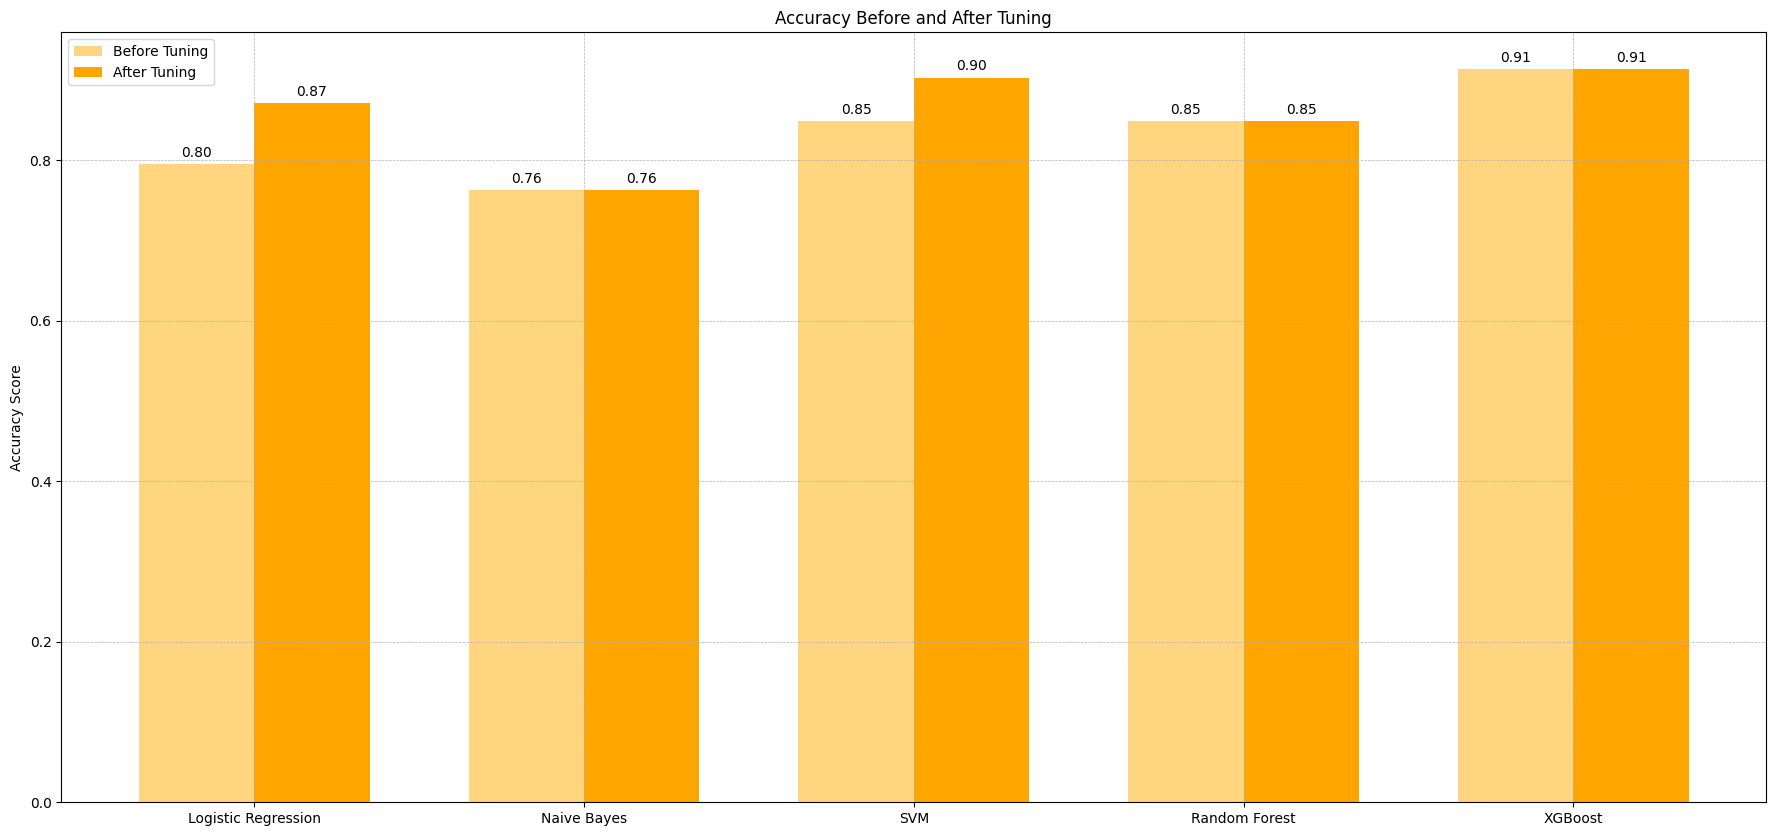

In [51]:
plot_performance(accuracy_before, accuracy_after, "Accuracy", "Accuracy Score")
plt.savefig("accuracy.png", format='png', dpi=200)
plt.show()

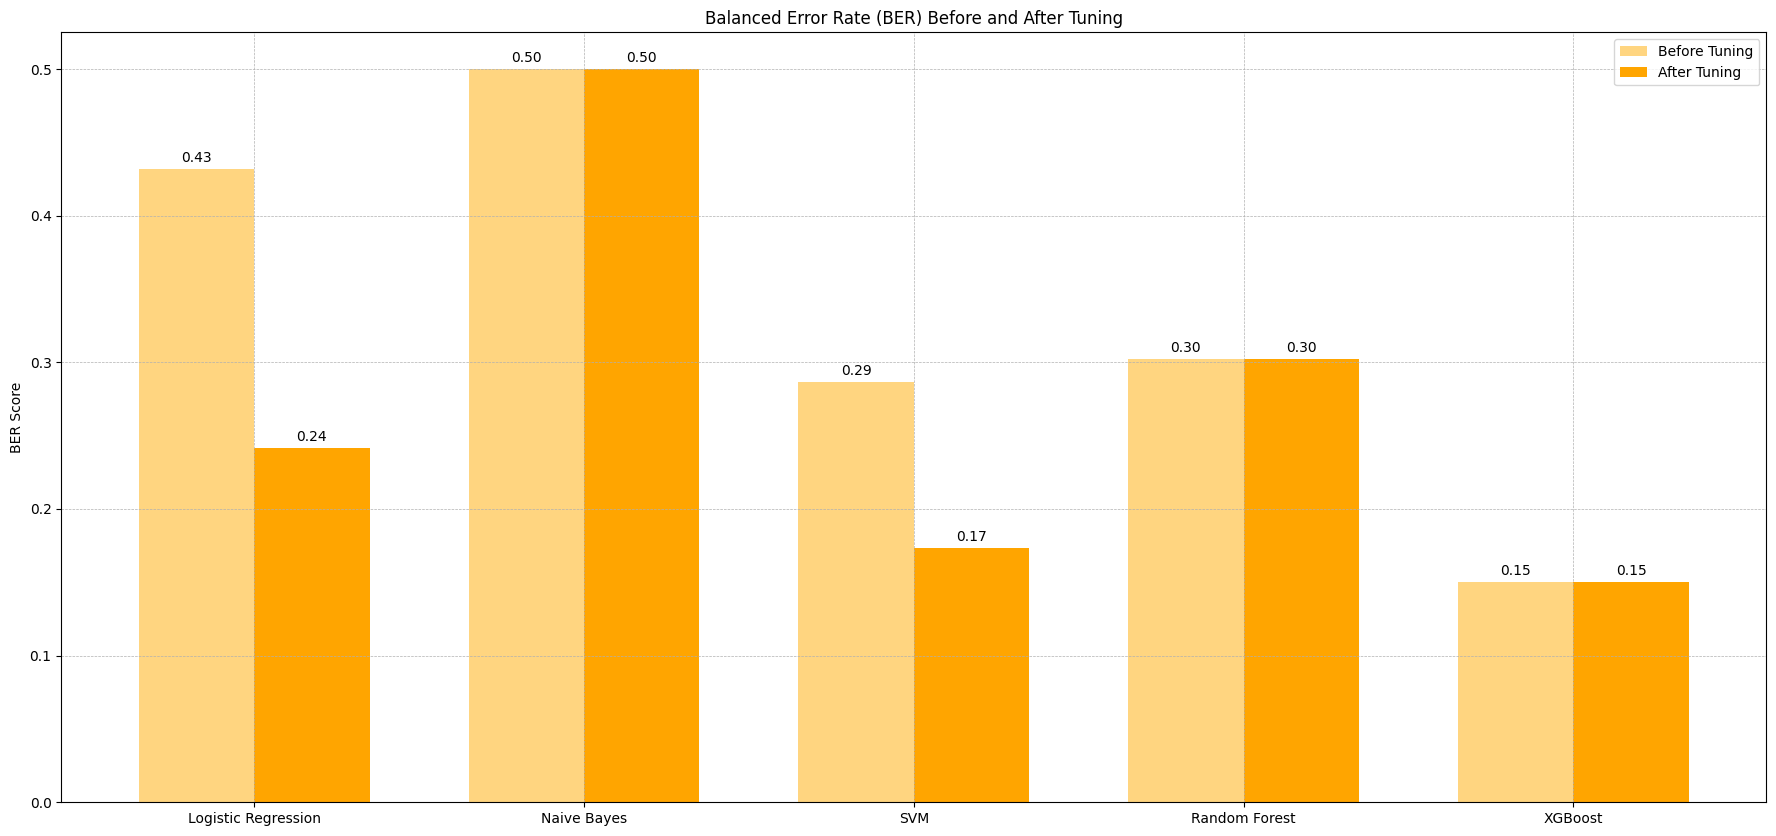

In [52]:
plot_performance(ber_before, ber_after, "Balanced Error Rate (BER)", "BER Score")
plt.savefig("ber.png", format='png', dpi=200)
plt.show()

In [54]:
# dataframe for further comparison with other models
tf_idf = pd.DataFrame({
    'model_name':models,
    'BER': ber_after,
    'recall': recall_after,
    'accuracy': accuracy_after
})

# save it to the respective folder
file_path = "data/tf_idf.csv"
tf_idf.to_csv(file_path, index=False)

# show tf_idf.csv
tf_idf

,model_name,BER,recall,accuracy
0,Logistic Regression,0.241357,0.545455,0.870968
1,Naive Bayes,0.500000,0.000000,0.763441
2,SVM,0.173175,0.681818,0.903226
3,Random Forest,0.302497,0.409091,0.849462
4,XGBoost,0.150448,0.727273,0.913978
